<a href="https://colab.research.google.com/github/Jvlia17/deep-learning/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projekt ten ma na celu przeprowadzenie ataku aderwsarzowego metodą FGSM na głęboką sieć neuronową o architekturze typu ResNet (*Residual neural network*). W projekcie sprawdzony zostanie wpływ parametru ɛ metody FGSM. W celu przeprowadzenia eksperymentów, zostanie wytrenowana sieć ResNet na zbiorze CIFAR-10. Zostanie sprawdzona metoda obrony przed takimi atakami, tj. dodanie rozmycia do obrazu wejściowego.

Na początku zatem należy stworzyć model. Architektura modelu została zaimplementowana na podstawie [[1]](https://arxiv.org/pdf/1512.03385.pdf) oraz [[2]](https://github.com/akamaster/pytorch_resnet_cifar10). Zaimplementowano model o 110 warstwach, ResNet110, jako że w jak podaje [[1]](https://arxiv.org/pdf/1512.03385.pdf), otrzymano na nim najmniejszy błąd dla zbioru CIFAR10.

https://github.com/akamaster/pytorch_resnet_cifar10

https://arxiv.org/pdf/1512.03385.pdf

https://medium.com/analytics-vidhya/resnet-10f4ef1b9d4c

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0

https://www.kaggle.com/code/banerz/resnet-implementation-in-pytorch

https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/



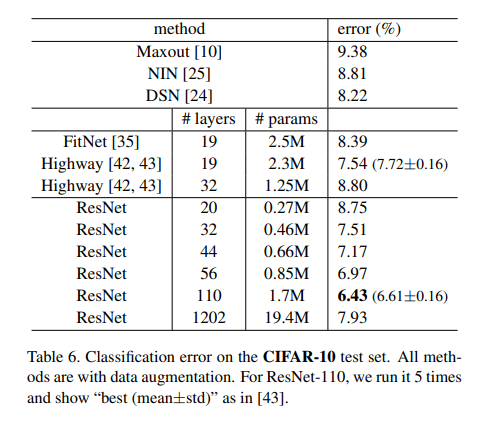

*We follow the simple data augmentation in [24] for training: 4 pixels arepadded on each side,
and a 32×32 crop is randomly sampled from the padded
image or its horizontal flip. For testing, we only evaluate
the single view of the original 32×32 image.*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchviz import make_dot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
!pip install t

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super().__init__()
        self.inplanes = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 16, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 32, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 64, layers[2], stride = 2)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = F.avg_pool2d(x, x.size()[3])
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

model = ResNet(ResidualBlock, [18,18,18]).to(device)

# summary(model, (3, 32, 32))

x = torch.randn(1,3,32, 32)
y = model(x)

make_dot(y.mean(), params=dict(model.named_parameters())).render("rnn_torchviz", format="png")


'rnn_torchviz.png'

In [ ]:
# Hyper-parameters
num_epochs = 200
batch_size = 128
learning_rate = 0.001
weight_decay = 0.0001 # ??
momentum = 0.9
# when the training error is below 80% go to lr=0.1

Wczytanie zbioru danych: